In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/sample_rock_set'
proj_folder_path = '/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/'
FULL_MIDI_LANG_DATA_path = '/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/Large_MIDI_Language_Base.parquet'
learning_rates_parq = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/learning_rates_df.parquet"
train_losses_parq = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/train_losses_df.parquet"
train_ppl_parq = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/train_ppl_df.parquet"
val_losses_parq = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/val_losses_df.parquet"
val_ppl_parq = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/val_ppl_df.parquet"
attention_weights_parq="/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/training_data/attention_weights_df.parquet"
latest_model = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/07-12-23_23:06_model_weights.pth"

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from music21 import chord, note, stream, clef, meter,converter
import os
from tqdm import tqdm
import datetime
from IPython.display import clear_output, Image, display
import PIL
import pandas as pd
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

## Extracting MIDI data from midi file

In [ ]:
# def open_midi(file_path):
#     try:
#         midi = converter.parse(file_path)
#         return midi
#     except Exception as e:
#         print(f"An error occurred while opening the MIDI file: {e}")

In [ ]:
# def create_data_set(dest_directory):
#     all_chords = []
#     for root, dirs, files in os.walk(dest_directory):
#         # print(dirs)
#         for f_i, _file in tqdm(enumerate(files), desc="Loaded: "):
#             mid_file = os.path.join(root, _file)
#             midi_data = open_midi(mid_file)
#             all_chords.append("<song_start>")
#             for i, part in enumerate(midi_data.parts):  # type: ignore
#                 all_chords.append(f"<part_start>")
#                 for element in part.recurse():
#                     # if isinstance(element, meter.TimeSignature):
#                     #     all_chords.append(element.ratioString)
#                     if isinstance(element, chord.Chord):
#                         all_chords.append("<meta>")
#                         all_chords.append(
#                             f"chord_quarterlength {element.duration.quarterLength.real}")
#                         all_chords.append(f"chord_offset {element.offset}")
#                         all_chords.append("<chord_start>")
#                         for note_i,n in enumerate(element):
#                             all_chords.append(
#                                 f"note_pitch index_{note_i} value_{n.pitch.midi}")  # type: ignore
#                             all_chords.append(
#                                 f"note_velocity index_{note_i} value_{n.volume.velocity}")
#                             all_chords.append(
#                                 f"note_quarterlength index_{note_i} value_{n.duration.quarterLength}")
#                             all_chords.append(f"note_offset index_{note_i} value_{n.offset}")
#                         all_chords.append("<chord_end>")
#             all_chords.append("<song_end>")

#     return all_chords


In [ ]:
# chord_set = create_data_set(folder_path)

Loaded: : 14it [00:51,  3.66s/it]


In [ ]:
# def filter_data(input_list):
#     filtered_list = []
#     part_start_flag = False

#     for element in input_list:
#         if element == '<part_start>':
#             part_start_flag = True
#         elif element == '<meta>' and part_start_flag:
#             filtered_list.append('<part_start>')
#             filtered_list.append(element)
#             part_start_flag = False
#         elif part_start_flag is False:
#             filtered_list.append(element)

#     return filtered_list


# filter_chord_set = filter_data(chord_set)

NameError: ignored

## THE MODEL

In [4]:
FULL_MIDI_LANG_DATA_list = pd.read_parquet(FULL_MIDI_LANG_DATA_path)["full_MIDI_lang_base"].values.tolist()
learning_rates = pd.read_parquet(learning_rates_parq)["learning_rates"].values.tolist()
train_losses = pd.read_parquet(train_losses_parq)["train_losses"].values.tolist()
val_losses = pd.read_parquet(val_losses_parq)["val_losses"].values.tolist()
train_ppl = pd.read_parquet(train_ppl_parq)["train_ppl"].values.tolist()
val_ppl = pd.read_parquet(val_ppl_parq)["val_ppl"].values.tolist()
attention_weights = pd.read_parquet(attention_weights_parq)["attention_weights"].values.tolist()

In [5]:
unique_chars = sorted(list(set(FULL_MIDI_LANG_DATA_list)))

vocab_size = len(unique_chars)
block_size = 128
max_length = 128
batch_size = 32


n_embd = 512
n_heads = 8
forward_expansion = 4 # multiple with n_embd
num_layers = 6
dim_feedforward = n_embd*forward_expansion

learning_rate = 0.0005
clip_value = 0.0004
dropout = 0.4

epochs = 100
max_iters = 1000
eval_interval = 50
eval_iters = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cpu'

In [7]:
#@title Dictionary, decoder and encoder
stoi = {ch: i for i, ch in enumerate(unique_chars)}
itos = {i: ch for i, ch in enumerate(unique_chars)}
def encode(s): return [stoi[c] for c in s]
def decode(l): return '\n'.join([itos[i] for i in l])

In [8]:
#@title Get Batch Function

MIDI_DATA_TENSOR = torch.tensor(encode(FULL_MIDI_LANG_DATA_list), dtype=torch.long)

n = int(0.9*len(MIDI_DATA_TENSOR))  # first 90% will be train, rest val
train_data = MIDI_DATA_TENSOR[:n]
val_data = MIDI_DATA_TENSOR[n:]
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [9]:
#@title Self Attention class
class SelfAttention(nn.Module):
    def __init__(self):
        super(SelfAttention, self).__init__()
        self.embed_size = n_embd
        self.heads = n_heads
        self.head_dim = n_embd // n_heads

        assert (
            self.head_dim * n_heads == n_embd
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(n_heads * self.head_dim, n_embd)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)
        # values, keys, queries: (N, S, H, E/H)        (32, 20, 8, 8)


        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # energy: (N, H, S, S)                         (32, 8, 20, 20)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))



        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        # attention: (N, H, S, S)                      (32, 8, 20, 20)


        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # out: (N, S, E)    (32, 20, 64)


        out = self.fc_out(out)
        # out: (N, S, E)    (32, 20, 64)
        return out


In [10]:
#@title Decoderblock Class
class DecoderBlock(nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention()
        self.norm1 = nn.LayerNorm(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)

        self.feed_forward = nn.Sequential(
            nn.Linear(n_embd, forward_expansion * n_embd),
            # self.feed_forward[0](x): (N, S, E*F)  (32, 20, 2048)
            nn.ReLU(),
            # self.feed_forward[2](self.feed_forward[0](x)): (32, 20, 64)
            nn.Linear(forward_expansion * n_embd, n_embd),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask=None):
        # query, key, value: (N, S, E)       (32, 20, 64)

        attention = self.attention(value, key, query, mask)
        # attention: (N, S, E)               (32, 20, 64)

        # attention_weights=attention


        x = self.dropout(self.norm1(attention + query))
        # x: (N, S, E)                       (32, 20, 64)

        forward = self.feed_forward(x) # -> runs a sequential class
        # forward: (N, S, E)                 (32, 20, 64)

        out = self.dropout(self.norm2(forward + x))
        # out: (N, S, E)                     (32, 20, 64)
        return out, attention


In [11]:
#@title Transformer Class
class MIDIGenModel(nn.Module):
    def __init__(self):
        super(MIDIGenModel, self).__init__()

        self.embed_size = n_embd
        self.device = device

        self.word_embedding = nn.Embedding(vocab_size, n_embd)
        # self.word_embedding(x): (N, S, E)             (32, 20, 64)

        self.position_embedding = nn.Embedding(max_length, n_embd)
        # self.position_embedding(positions): (N, S, E) (32, 20, 64)


        self.layers = nn.ModuleList(
            [
                DecoderBlock()
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(n_embd, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, targets=None):
        # x: (N, S)                                     (32, 20)
        N, seq_length = x.shape


        positions = (
            torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        )

        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )
        # out: (N, S, E)                                (32, 20, 64)
        mask = torch.tril(torch.ones((seq_length, seq_length))
               .type(torch.BoolTensor)
               ).to(self.device)

        attention_weights = []
        for layer in self.layers:
            # each transformer block
            out, attn_weight = layer(out, out, out, mask) # out: (N, S, E) (32, 20, 64)
            attention_weights.append(attn_weight)

        out = self.fc_out(out) # (32, 20, 64)

        if targets is None:
            loss = None

        else:
            B, T, C = out.shape
            logits = out.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return out, loss,attention_weights

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [12]:
#@title Loss Function
@torch.no_grad()
def estimate_loss():
    out = {}
    attn ={
        "train":{
            "attention_weight":None,
            "input":None,
            "target":None
            },
        "val":{
            "attention_weight":None,
            "input":None,
            "target":None
            }
    }
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss, attn_wei = model(X, Y)
            losses[k] = loss.item()
            # if k % 50 == 0:
            if k == eval_iters-1:
                attn[split]["attention_weight"] = attn_wei[-1][-1].cpu().detach().numpy()
                attn[split]["input"]= X[-1].cpu().detach().numpy()
                attn[split]["target"] = Y[-1].cpu().detach().numpy()
            #
        out[split] = losses.mean()
    model.train()
    return out,attn

## Model Instantiation

In [ ]:
model = MIDIGenModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, "M parameters")

15.403035 M parameters


In [14]:
device

'cpu'

In [13]:
#@title Instantiate a saved model
model = MIDIGenModel()
model.load_state_dict(torch.load(latest_model))
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, "M parameters")

RuntimeError: ignored

In [ ]:
torch.cuda.empty_cache()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
#@title Grad Flow Function Depracated
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems. '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
            max_grads.append(p.grad.abs().max().cpu().detach().numpy())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    display(plt.gcf())

    clear_output(wait=True)


## Plotting

In [ ]:
def plot_grad_flow(named_parameters, fig):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ax = fig.add_subplot(2, 2, 1)
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
            # max_grads.append(p.grad.abs().max().cpu().detach().numpy())
    ax.barh(range(len(ave_grads)), ave_grads, align='center')
    ax.set_yticks(range(len(ave_grads)))
    ax.set_yticklabels(layers)
    ax.set_xlabel('average gradient')
    ax.set_title('Gradient flow')
    ax.grid(True)
    fig.savefig("grad_flow.png")


In [ ]:
def plot_learning_rate(learning_rates, fig):
    ax = fig.add_subplot(2, 2, 2)
    if len(learning_rates) >200:
        ax.plot(learning_rates[-200:])
    else:
        ax.plot(learning_rates)
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.grid(True)

In [ ]:
def plot_losses(train_losses, val_losses, fig):
    ax = fig.add_subplot(2, 2, 3)
    if len(train_losses) > 200 and len(val_losses) > 200:
        ax.plot(train_losses[-200:], label='Train Loss')
        ax.plot(val_losses[-200:], label='Validation Loss')
        ax.scatter(len(train_losses[-200:])-1, train_losses[-1], color='blue')
        ax.vlines(len(train_losses[-200:])-1, 0, train_losses[-1], linestyle='dashed', color='blue')
        ax.text(len(train_losses[-200:])-1, train_losses[-1], f'Train Loss: {train_losses[-1]:.4f}',
                verticalalignment='bottom', horizontalalignment='right')

        # Plot latest validation loss as a dot
        ax.scatter(len(val_losses[-200:])-1, val_losses[-1], color='orange')
        ax.vlines(len(val_losses[-200:])-1, 0, val_losses[-1], linestyle='dashed', color='orange')
        ax.text(len(val_losses[-200:])-1, val_losses[-1], f'Val Loss: {val_losses[-1]:.4f}',
            verticalalignment='bottom', horizontalalignment='right')
    else:
        ax.plot(train_losses, label='Train Loss')
        ax.plot(val_losses, label='Validation Loss')
        ax.scatter(len(train_losses)-1, train_losses[-1], color='blue')
        ax.vlines(len(train_losses)-1, 0, train_losses[-1], linestyle='dashed', color='blue')
        ax.text(len(train_losses)-1, train_losses[-1], f'Train Loss: {train_losses[-1]:.4f}',
                verticalalignment='bottom', horizontalalignment='right')

        # Plot latest validation loss as a dot
        ax.scatter(len(val_losses)-1, val_losses[-1], color='orange')
        ax.vlines(len(val_losses)-1, 0, val_losses[-1], linestyle='dashed', color='orange')
        ax.text(len(val_losses)-1, val_losses[-1], f'Val Loss: {val_losses[-1]:.4f}',
            verticalalignment='bottom', horizontalalignment='right')

    # Remove previous annotation
    # Plot latest train loss as a dot


    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)


In [ ]:
def plot_perplexities(train_ppl, val_ppl, fig):
    ax = fig.add_subplot(2, 2, 4)
    if len(train_ppl) >200 and len(val_ppl)>200:
        ax.plot(train_ppl[-200:], label='Train Perplexity')
        ax.plot(val_ppl[-200:], label='Validation Perplexity')
    else:
        ax.plot(train_ppl, label='Train Perplexity')
        ax.plot(val_ppl, label='Validation Perplexity')
    ax.set_xlabel('Step')
    ax.set_ylabel('Perplexity')
    ax.legend()
    ax.grid(True)

In [ ]:
def plot_attention():
    fig, axs = plt.subplots(figsize=(10, 10))

    # Consider only first n tokens
    # sentence = sentence[:n]
    # attention_weights = attention_weights[:n, :n]
    if attention_weights is not None:
        cax = axs.matshow(attention_weights.cpu().detach().numpy(), cmap='bone')
        fig.colorbar(cax)

        axs.set_xticklabels([''] + sentence, rotation=90)
        axs.set_yticklabels([''] + sentence)

        axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
        axs.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

## Training

In [ ]:
#@title Training _deprecated
%matplotlib inline
for iter in range(max_iters):

    losses = estimate_loss()
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])
    train_ppl.append(torch.exp(losses['train']))
    val_ppl.append(torch.exp(losses['val']))
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses_interval = estimate_loss()
        print(f"step {iter}: train loss {losses_interval['train']:.4f}, val loss {losses_interval['val']:.4f}")
        # calculate perplexity
        train_ppl_inter = torch.exp(losses_interval['train'])
        val_ppl_inter = torch.exp(losses_interval['val'])
        print(f"step {iter}: train perplexity {train_ppl_inter:.4f}, val perplexity {val_ppl_inter:.4f}")
        learning_rates.append(optimizer.param_groups[0]['lr'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    plot_grad_flow(model.named_parameters())
    optimizer.step()
    scheduler.step()

In [ ]:
attention_weights=[]

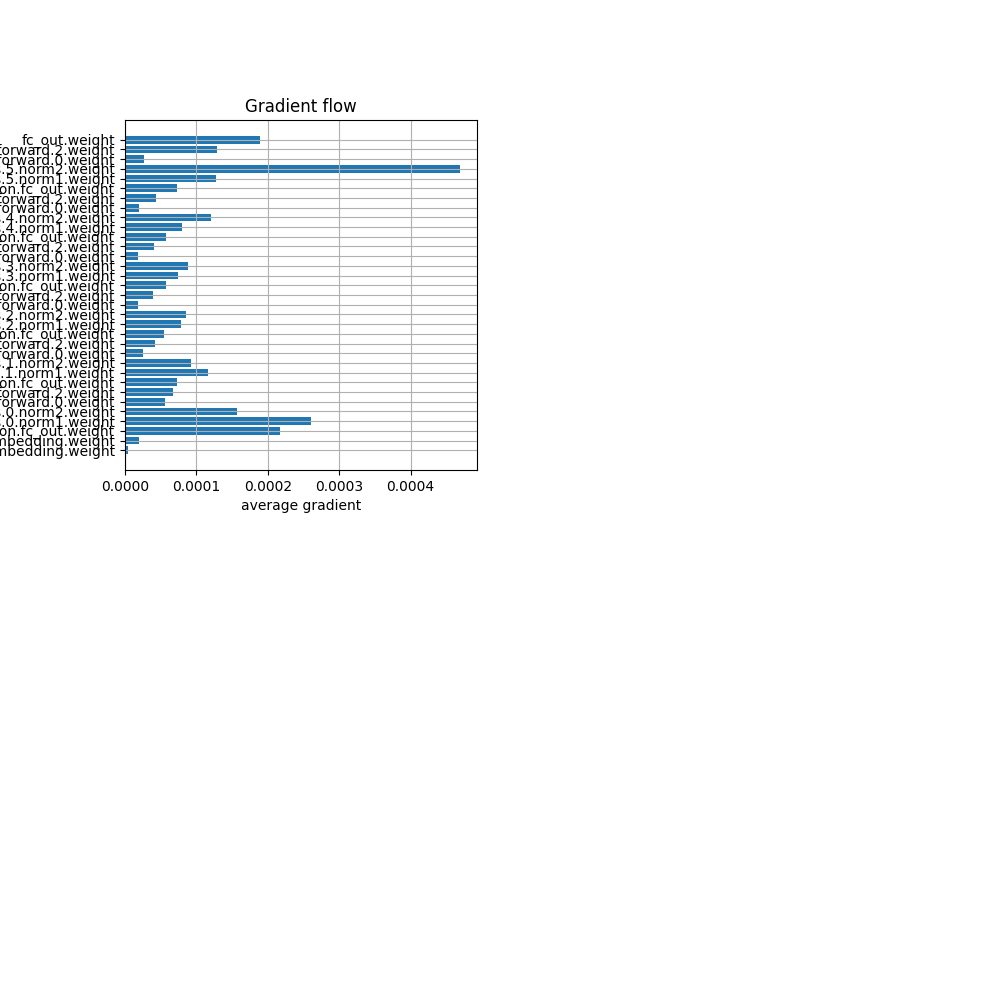

KeyboardInterrupt: ignored

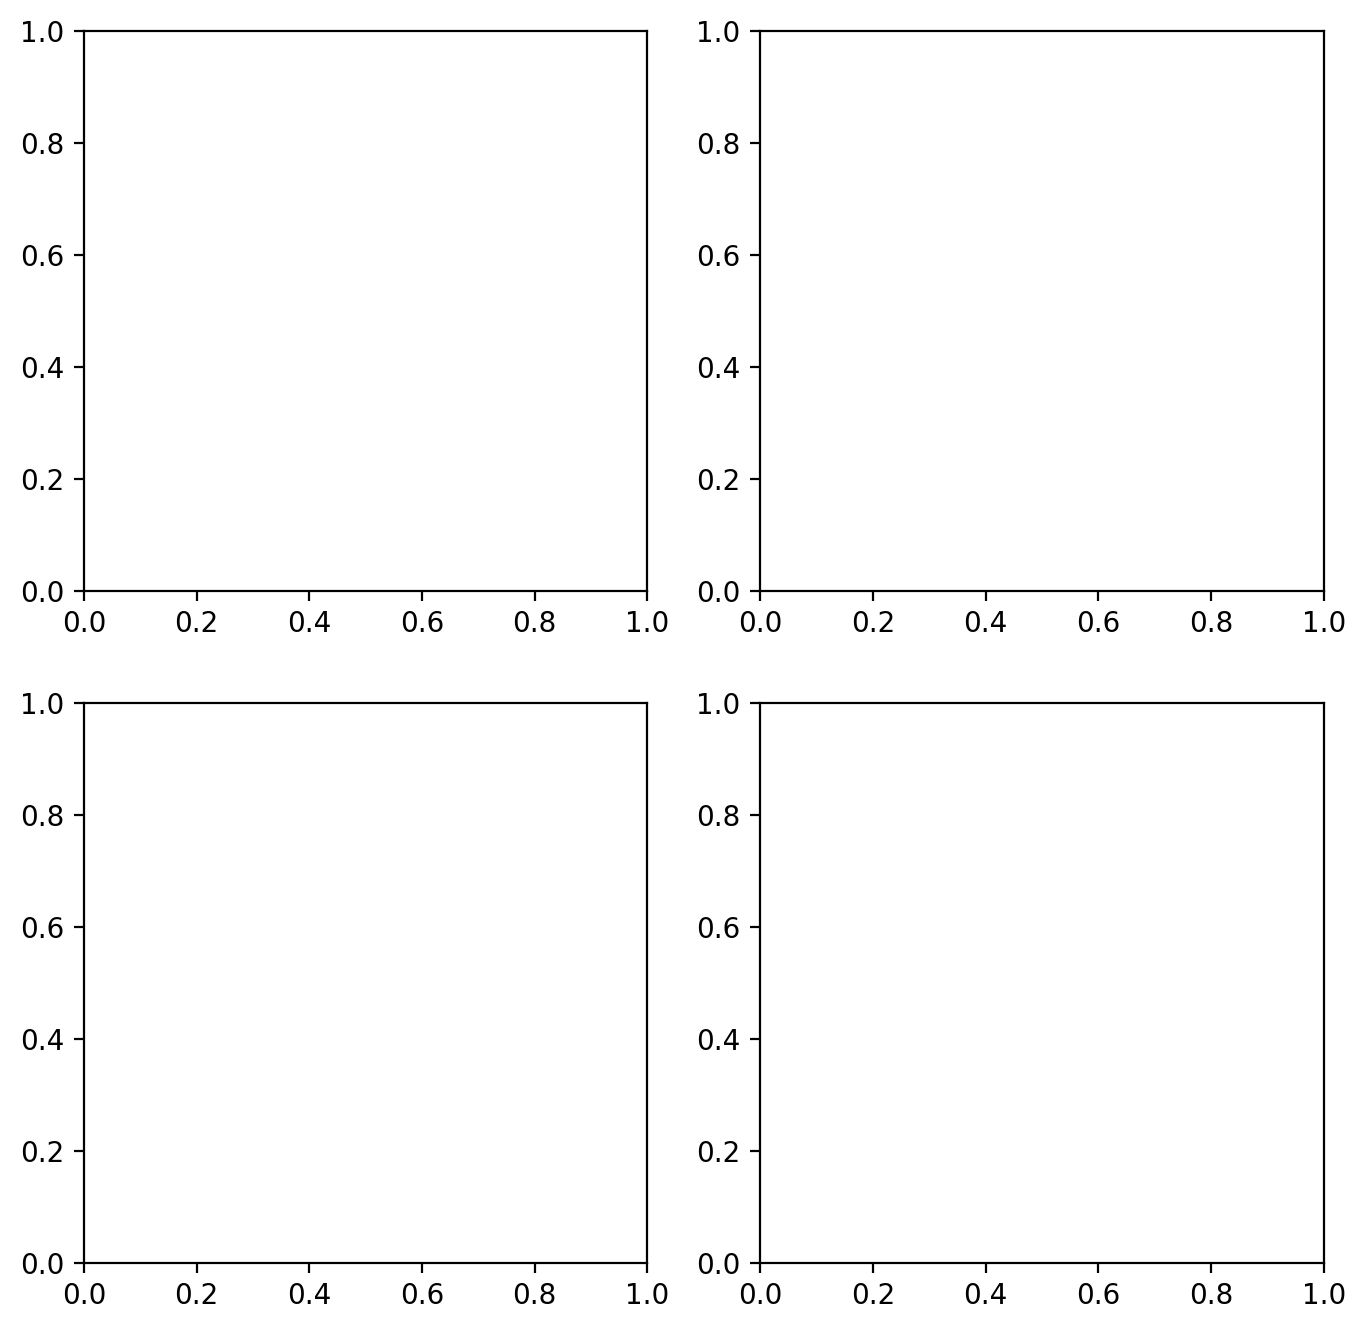

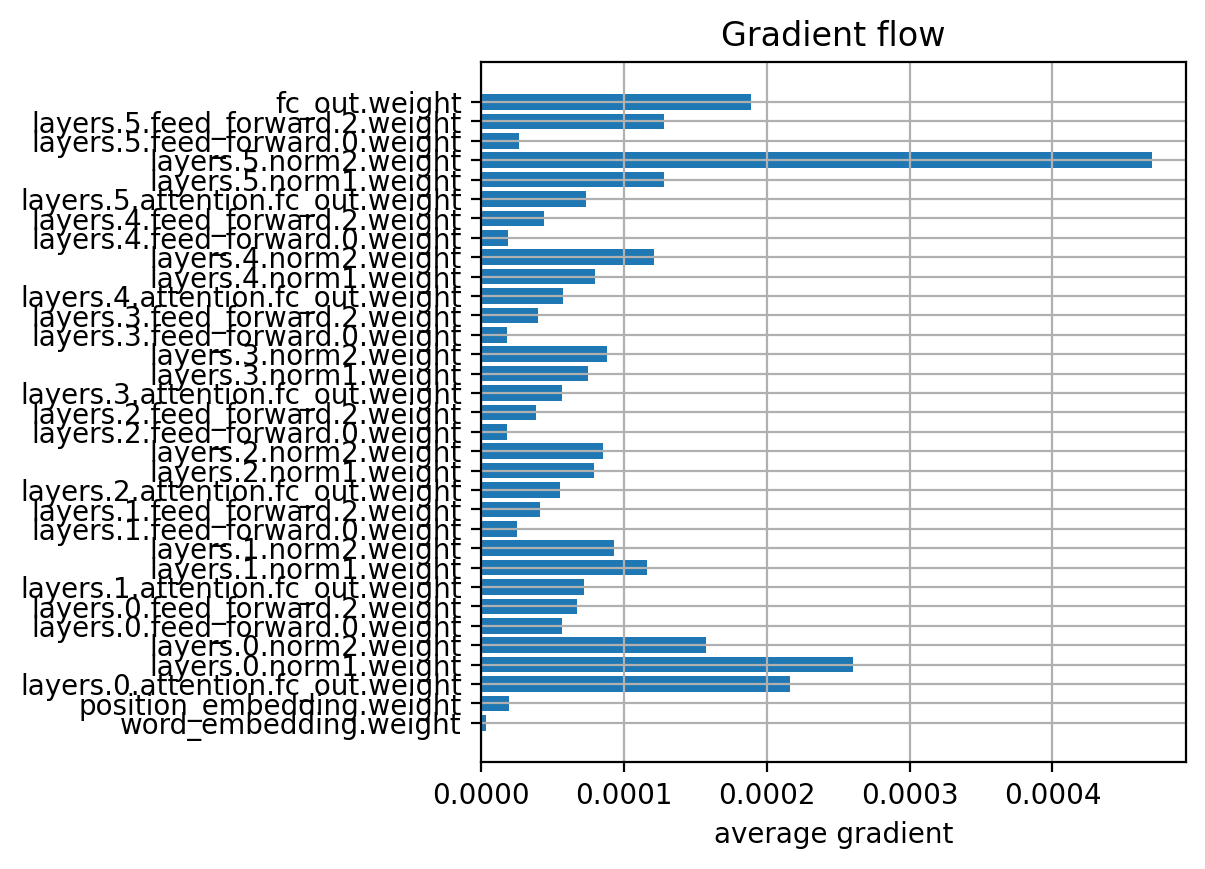

In [ ]:
#@title Training
%matplotlib inline
# Initialize figure for plotting
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.ion()

for iter in range(max_iters):

    losses, attn = estimate_loss()
    attention_weights.append(attn)
    train_losses.append(losses['train'].item())
    val_losses.append(losses['val'].item())
    train_ppl.append(torch.exp(losses['train']).item())
    val_ppl.append(torch.exp(losses['val']).item())
    lr = optimizer.param_groups[0]['lr']
    learning_rates.append(lr)
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        print(f"iter::{iter} train_losses {losses['train'].item()} \nval_losses {losses['val'].item()}")
        print(f"iter::{iter} train_ppl {torch.exp(losses['train']).item()} \nval_ppl {torch.exp(losses['val']).item()}")
        print(f"learning_rate:: {lr}")
        print("")
        fig = plt.figure(figsize=(10,10))

        # Draw the gradient flow plot
        plot_grad_flow(model.named_parameters(), fig)

        # Draw the other plots
        # plot_learning_rate(learning_rates, fig)
        # plot_losses(train_losses, val_losses, fig)
        # plot_perplexities(train_ppl, val_ppl, fig)
        # plot_attention()
        # Save the figure with all the plots
        fig.savefig("all_plots.png")

        # Clear the previous plot and display the new one
        clear_output(wait=True)
        display(Image(filename="all_plots.png"))

    if losses['train'].item() < 1.9:
        break
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss, _ = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
    scheduler.step()

In [ ]:
train_losses[-1]

1.994612216949463

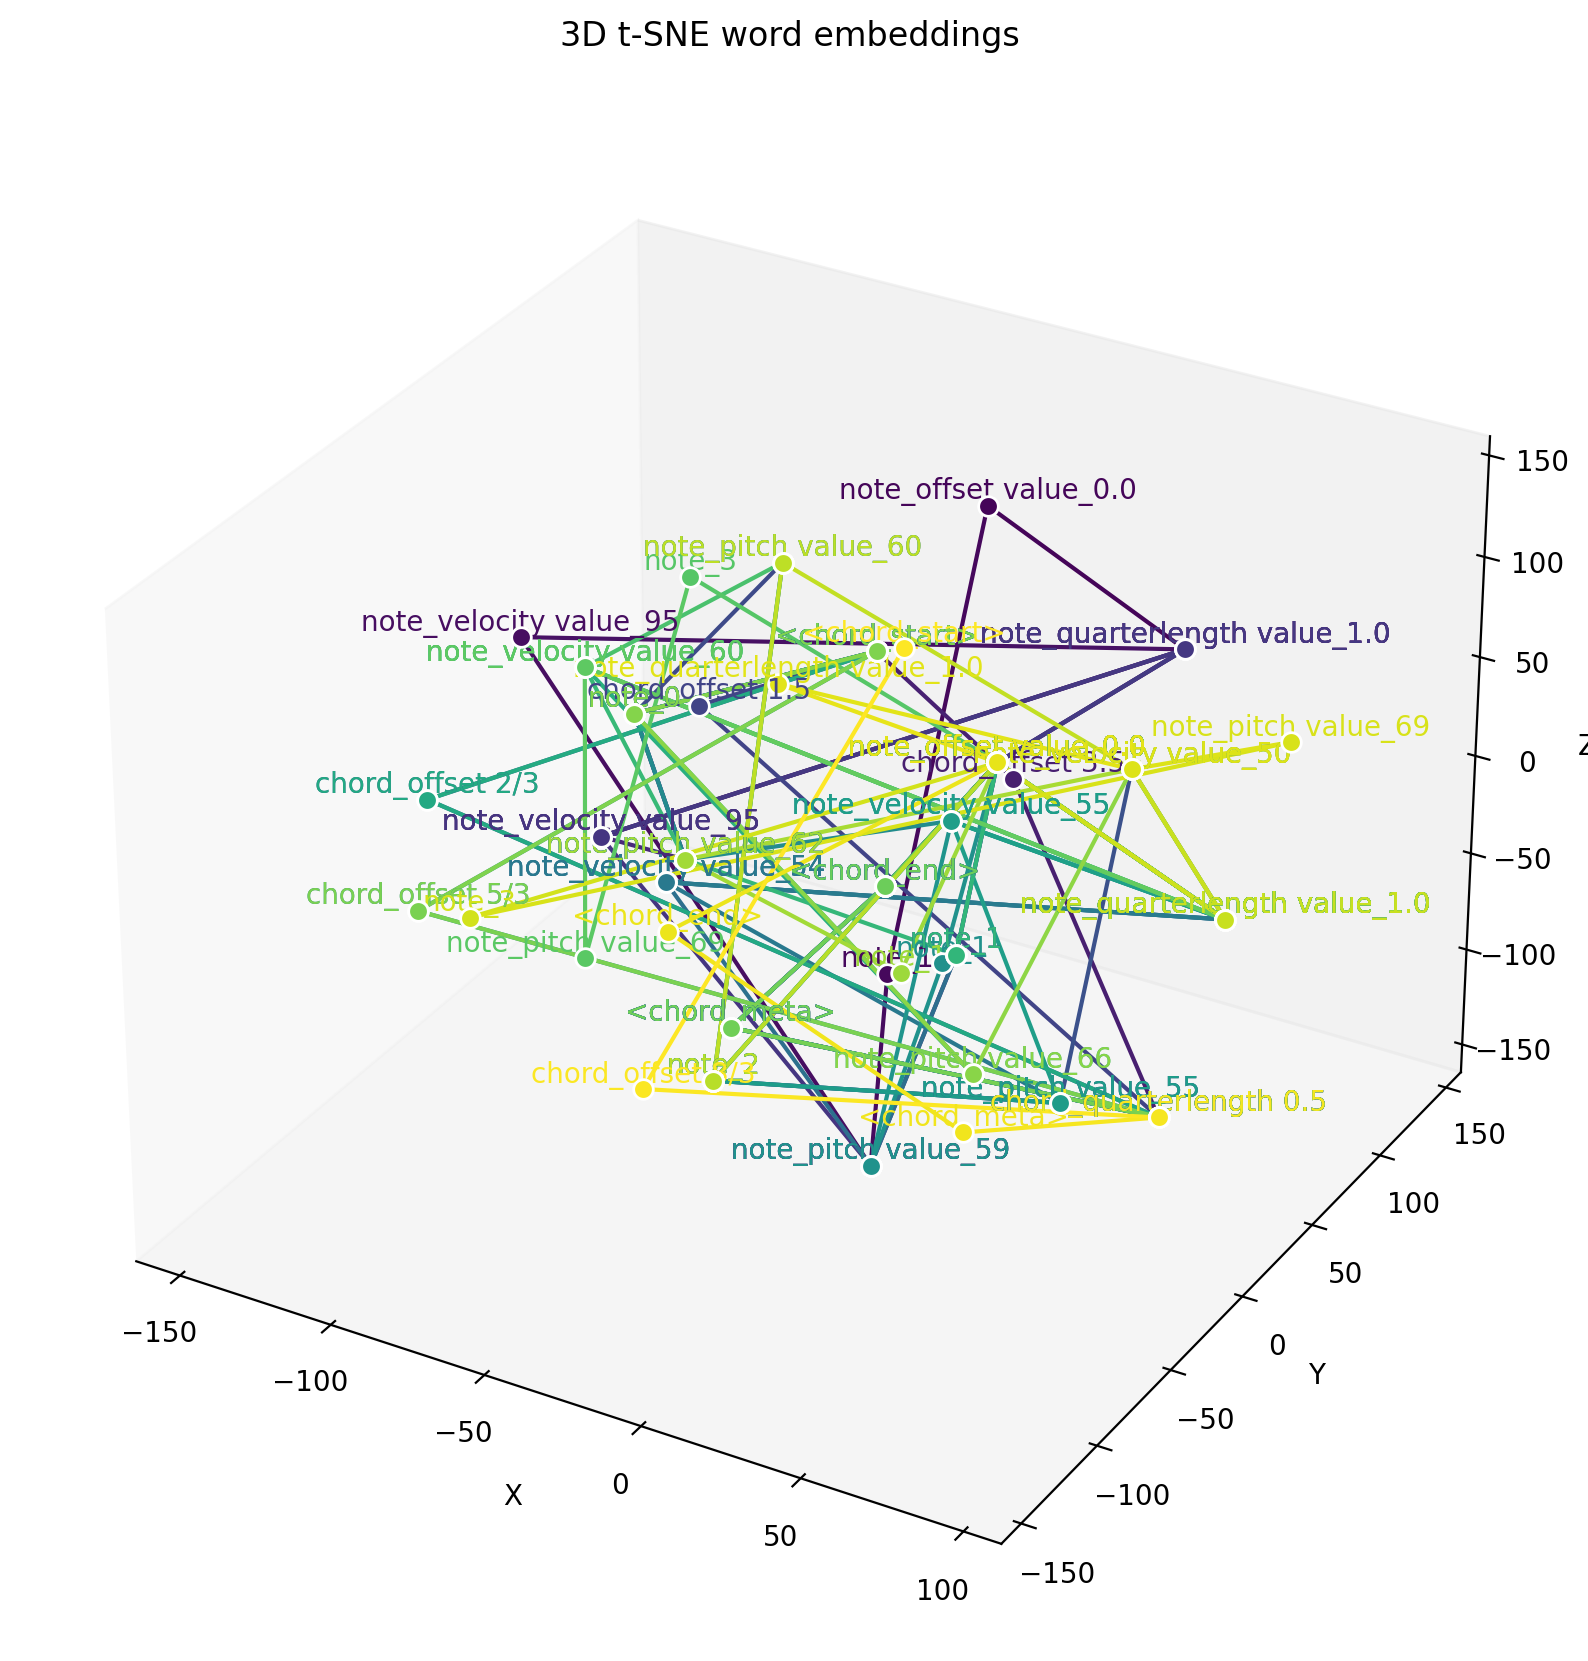

In [ ]:
#@title 3d Word embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# from adjustText import adjust_text

# Let's say we have a word_embedding layer in our model and we want to visualize the embeddings for specific words
words = FULL_MIDI_LANG_DATA_list[100:130]+FULL_MIDI_LANG_DATA_list[50_000:50_100]
word_ids = [stoi[word] for word in words]  # assume `vocab` is your vocabulary mapping words to indices

# Extract the embeddings for these words from the embedding layer
embeddings = model.word_embedding(torch.tensor(word_ids, device=device)).cpu().detach().numpy()

# Apply t-SNE to the embeddings
embeddings_tsne = TSNE(n_components=3, perplexity=1).fit_transform(embeddings)

# Plot the embeddings
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
# ax.xaxis.pane.set_edgecolor('black')
# ax.yaxis.pane.set_edgecolor('black')
# ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True

colors = plt.cm.viridis(np.linspace(0, 1, len(words)))

texts = []
for i, word in enumerate(words):
    if word.startswith("note_pitch"):
        pitch_name =
        x, y, z = embeddings_tsne[i, :]
        ax.scatter(x, y, z, color=colors[i], s=50, edgecolors='w')
        texts.append(ax.text(x, y, z, word, color=colors[i], ha='center', va='bottom'))
        if i > 0:  # connect points from the second one
            prev_x, prev_y, prev_z = embeddings_tsne[i-1, :]
            ax.plot([prev_x, x], [prev_y, y], [prev_z, z], color=colors[i])

# adjust_text(texts)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D t-SNE word embeddings', pad=20)

plt.show()


In [ ]:
torch.cuda.memory_allocated()

14862060544

In [ ]:
current_time = datetime.datetime.now().strftime('%m-%d-%y_%H:%M')
model_path = os.path.join(proj_folder_path,f'{current_time}_model_weights.pth')
torch.save(m.state_dict(), model_path)

In [ ]:
# train_losses, val_losses, train_ppl, val_ppl, learning_rates
train_losses_df = pd.DataFrame(train_losses, columns=['train_losses'])
val_losses_df = pd.DataFrame(val_losses, columns=['val_losses'])
train_ppl_df = pd.DataFrame(train_ppl, columns=['train_ppl'])
val_ppl_df = pd.DataFrame(val_ppl, columns=['val_ppl'])
learning_rates_df = pd.DataFrame(learning_rates, columns=['learning_rates'])
attention_weights_df = pd.DataFrame(attention_weights, columns=["attention_weights"])

train_losses_df.to_parquet(os.path.join(proj_folder_path,"training_data", "train_losses_df.parquet"))
val_losses_df.to_parquet(os.path.join(proj_folder_path,"training_data",  "val_losses_df.parquet"))
train_ppl_df.to_parquet(os.path.join(proj_folder_path, "training_data", "train_ppl_df.parquet"))
val_ppl_df.to_parquet(os.path.join(proj_folder_path,"training_data",  "val_ppl_df.parquet"))
learning_rates_df.to_parquet(os.path.join(proj_folder_path, "training_data", "learning_rates_df.parquet"))
attention_weights_df.to_parquet(os.path.join(proj_folder_path, "training_data", "attention_weights_df.parquet"))

2.005599021911621

# Load Pretrained Weights

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/MIDI-gen-notebooks/07-10-23_03:05_model_weights.pth"
model_gen = MIDIGenModel()
model_gen.load_state_dict(torch.load(model_path))
model_gen = model_gen.to(device)

In [ ]:
#@title File Upload

from google.colab import files

print("Please upload a MIDI file:")
#@markdown Run This block to upload file
uploaded = files.upload()

for fn in uploaded.keys():
    midi_file = fn
# Process the file content here


Please upload a MIDI file:


Saving sample.mid to sample.mid


In [ ]:
def create_vocab(mid_file):
    all_chords = []

    midi_data = open_midi(mid_file)
    all_chords.append("<song_start>")
    for i, part in enumerate(midi_data.parts):  # type: ignore
        all_chords.append(f"<part_start>")
        for element in part.recurse():
            # if isinstance(element, meter.TimeSignature):
            #     all_chords.append(element.ratioString)
            if isinstance(element, chord.Chord):
                all_chords.append("<meta>")
                all_chords.append(
                    f"chord_quarterlength {element.duration.quarterLength.real}")
                all_chords.append(f"chord_offset {element.offset}")
                all_chords.append("<chord_start>")
                for note_i,n in enumerate(element):
                    all_chords.append(
                        f"note_pitch index_{note_i} value_{n.pitch.midi}")  # type: ignore
                    all_chords.append(
                        f"note_velocity index_{note_i} value_{n.volume.velocity}")
                    all_chords.append(
                        f"note_quarterlength index_{note_i} value_{n.duration.quarterLength}")
                    all_chords.append(f"note_offset index_{note_i} value_{n.offset}")
                all_chords.append("<chord_end>")
    all_chords.append("<song_end>")

    return all_chords


In [ ]:
primer = create_vocab(midi_file)

NameError: ignored

In [ ]:
primer = [stoi[midi_word] for midi_word in primer]

In [ ]:
primer

In [ ]:
context = torch.tensor([primer],dtype=torch.long, device=device)

In [ ]:
itos[95]

'note_pitch index_0 value_49'

In [ ]:
generated_out = model_gen.generate(context, 40)[0].tolist()

In [ ]:
for i in generated_out:
    print(itos[i])

<song_start>
<part_start>
<meta>
chord_quarterlength 1.0
chord_offset 0.0
<chord_start>
note_pitch index_0 value_60
note_velocity index_0 value_100
note_quarterlength index_0 value_1.0
note_offset index_0 value_0.0
note_pitch index_1 value_65
note_velocity index_1 value_100
note_quarterlength index_1 value_1.0
note_offset index_1 value_0.0
note_pitch index_2 value_69
note_velocity index_2 value_100
note_quarterlength index_2 value_1.0
note_offset index_2 value_0.0
<chord_end>
<song_end>
chord_offset 0.0
<chord_start>
note_pitch index_0 value_64
note_velocity index_0 value_61
note_quarterlength index_0 value_1.0
note_offset index_0 value_0.0
note_pitch index_1 value_43
note_velocity index_1 value_127
note_quarterlength index_1 value_1.0
note_offset index_1 value_0.0
note_pitch index_2 value_54
note_velocity index_5 value_102
note_velocity index_3 value_101
note_quarterlength index_1 value_1.0
note_offset index_1 value_0.0
note_pitch index_2 value_55
note_velocity index_2 value_80
note_q

In [ ]:
out_midi_list = []
for i in generated_out:
    out_midi_list.append(itos[i])

In [ ]:
import re

def parse_list_to_midi(input_list, output_file):
    # Initialize main objects
    current_stream = None
    current_part = None
    current_chord = None
    quarter_length=None
    offset = None

    for line in input_list:
        if '<song_start>' in line:
            current_stream = stream.Stream()

        elif '<part_start>' in line:
            current_part = stream.Part()

        elif '<meta>' in line:
            quarter_length_match = re.search('chord_quarterlength ([0-9.]+)', line)
            offset_match = re.search('chord_offset ([0-9.]+)', line)

            if offset_match is not None:
                offset = float(offset_match.group(1))

            if quarter_length_match is not None:
                quarter_length = float(quarter_length_match.group(1))
            else:
                print("Warning: 'chord_quarterlength' not found!")

            if offset_match is not None:
                offset = float(offset_match.group(1))
            else:
                print("Warning: 'chord_offset' not found!")

        elif '<chord_start>' in line:
            current_chord = chord.Chord()

        elif '<chord_end>' in line:
            if current_chord is not None:
                current_chord.duration.quarterLength = quarter_length
                if offset is not None:  # add this line
                    current_chord.offset = offset
                current_part.append(current_chord)
            else:
                print("Warning: encountered <chord_end> but no chord is active!")

        elif 'note_pitch' in line:

            pitch_match = re.search('value_([0-9]+)', line)
            if pitch_match is not None:
                pitch = int(pitch_match.group(1))
            else:
                print("Warning: 'value_' not found for pitch!")
            current_note = note.Note(pitch)

            if 'note_velocity' in line:
                velocity = int(re.search('value_([0-9]+)', line).group(1))
                current_note.volume.velocity = velocity

            if 'note_quarterlength' in line:
                length = float(re.search('value_([0-9.]+)', line).group(1))
                current_note.duration.quarterLength = length

            if 'note_offset' in line:
                offset = float(re.search('value_([0-9.]+)', line).group(1))
                current_note.offset = offset

            if current_chord is not None:
                current_chord.add(current_note)
            else:
                print("Warning: encountered 'note_pitch' but no chord is active!")

        elif '<part_end>' in line:
            if current_part is not None:
                current_stream.append(current_part)
                current_part = stream.Part()
            else:
                print("Warning: encountered <part_end> but no part is active!")

        elif '<song_end>' in line:
            if current_stream is not None:
                if current_part is not None:
                    current_stream.append(current_part)
                current_stream.write('midi', fp=output_file)
            else:
                print("Warning: encountered <song_end> but no song is active!")


In [ ]:
output_file = 'output.mid'  # the name of the output file
parse_list_to_midi(out_midi_list, output_file)

AttributeError: ignored